Unsupervised Eye-Tracking Analysis

In the unsupervised portion of this analysis, we first standardized a selection of critical eye-tracking metrics (e.g., fixation duration, fixation count, saccade count, pupil size) from five metric catergories. Next, we employed HDBSCAN clustering to discover natural groupings or hidden strategy types in the data without relying on predefined labels. 

We then visualized these clusters using UMAP dimensionality reduction to interpret their spatial organization clearly.

This method allowed us to objectively identify distinct gaze behavior patterns that could later be associated with cognitive strategies and performance accuracy.

In [43]:
# Load Cleaned and Rated Data
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import math


# Update path to your cleaned eye-tracking dataset
df = pd.read_csv("../data/eye_tracking_rated.csv")
df.head()

,RECORDING_SESSION_LABEL,INDEX,AVERAGE_BLINK_DURATION,AVERAGE_FIXATION_DURATION,AVERAGE_SACCADE_AMPLITUDE,AVERAGE_X_RESOLUTION,AVERAGE_Y_RESOLUTION,BLINK_COUNT,BUTTON_PRESS_COUNT,BUTTON_RELEASE_COUNT,...,START_TIME,TRIAL_LABEL,VISITED_INTEREST_AREA_COUNT,Session_Name_,Trial_Index_,result,trialid,key,response_num,response
0,ET24_066,2,140,366.88,5.45,56.87,57.27,3,0,0,...,92190160,Trial: 2,6,ET24_066,1,choice5,4,5,5.0,1
1,ET24_066,3,178,354.98,5.54,56.73,57.10,5,0,0,...,92216758,Trial: 3,6,ET24_066,2,choice1,12,1,1.0,1
2,ET24_066,4,5788,.,12.28,59.00,57.80,1,0,0,...,92242664,Trial: 4,0,ET24_066,3,choice3,1,3,3.0,1
3,ET24_066,5,13560,.,12.4,58.40,57.50,1,0,0,...,92250758,Trial: 5,0,ET24_066,4,choice3,18,1,3.0,0
4,ET24_066,6,7765,206.57,8.63,53.41,53.66,2,0,0,...,92266772,Trial: 6,5,ET24_066,5,choice3,6,3,3.0,1


In [7]:
# Select variables
variables = [
    "RECORDING_SESSION_LABEL",
    "trialid",
    "response",
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]

# Extract selected metrics
df_selected = df[variables]

df_selected.head()

df_selected.to_csv("../data/eye_tracking_metrics_selected.csv", index=False)

In [8]:
# Replace "." with np.nan without inplace
df_selected = df_selected.replace(".", np.nan)

# Create a copy of the dataframe to store numeric values
df_selected_numeric = df_selected.copy()  # Create df_selected_numeric first

exclude_columns = ['RECORDING_SESSION_LABEL', 'trialid', 'response']

# Convert columns to numeric and then to int64 where possible
for col in df_selected.columns:
    # Skip the columns we want to keep as is
    if col not in exclude_columns:
        # First convert to numeric (this will create float values)
        df_selected_numeric[col] = pd.to_numeric(df_selected[col], errors='coerce')
    
# Check the result
#df_selected_numeric.info()
df_selected_numeric.head()

,RECORDING_SESSION_LABEL,trialid,response,AVERAGE_FIXATION_DURATION,FIXATION_COUNT,FIXATION_DURATION_MAX,FIXATION_DURATION_MIN,MEDIAN_FIXATION_DURATION,SD_FIXATION_DURATION,AVERAGE_SACCADE_AMPLITUDE,...,PUPIL_SIZE_MEAN,PUPIL_SIZE_MAX,PUPIL_SIZE_MIN,AVERAGE_BLINK_DURATION,BLINK_COUNT,RUN_COUNT,IA_COUNT,VISITED_INTEREST_AREA_COUNT,DURATION,IP_DURATION
0,ET24_066,4,1,366.88,57,1011.0,90.0,368.0,198.33,5.45,...,597.68,691.0,530.0,140.0,3,32,7,6,23799,23714
1,ET24_066,12,1,354.98,57,1134.0,36.0,308.0,206.06,5.54,...,580.97,718.0,503.0,178.0,5,26,7,6,23699,23619
2,ET24_066,1,1,NaN,0,NaN,NaN,NaN,NaN,12.28,...,NaN,NaN,NaN,5788.0,1,0,7,0,5825,5735
3,ET24_066,18,0,NaN,0,NaN,NaN,NaN,NaN,12.40,...,NaN,NaN,NaN,13560.0,1,0,7,0,13597,13518
4,ET24_066,6,1,206.57,7,416.0,8.0,234.0,142.05,8.63,...,508.65,527.0,491.0,7765.0,2,5,7,5,17349,17270


                              count      mean       std      min      25%  \
AVERAGE_FIXATION_DURATION    1559.0    312.97    307.14    36.00   246.88   
FIXATION_COUNT               1582.0     42.89     36.21     0.00    19.00   
FIXATION_DURATION_MAX        1559.0   1123.83    775.30    36.00   674.00   
FIXATION_DURATION_MIN        1559.0     68.30    303.84     0.00    28.00   
MEDIAN_FIXATION_DURATION     1559.0    246.50    302.38    32.00   200.00   
SD_FIXATION_DURATION         1559.0    227.27    121.25     0.00   154.14   
AVERAGE_SACCADE_AMPLITUDE    1564.0      4.80      1.33     0.00     4.04   
MEDIAN_SACCADE_AMPLITUDE     1579.0      2.84      1.70     0.00     1.67   
SACCADE_COUNT                1582.0     42.13     36.18     0.00    18.00   
SD_SACCADE_AMPLITUDE         1579.0      4.64      1.45     0.00     3.84   
PUPIL_SIZE_MEAN              1558.0    666.45    200.86    45.16   529.56   
PUPIL_SIZE_MAX               1558.0    887.69    475.30    85.00   652.00   

<Figure size 1500x1000 with 0 Axes>

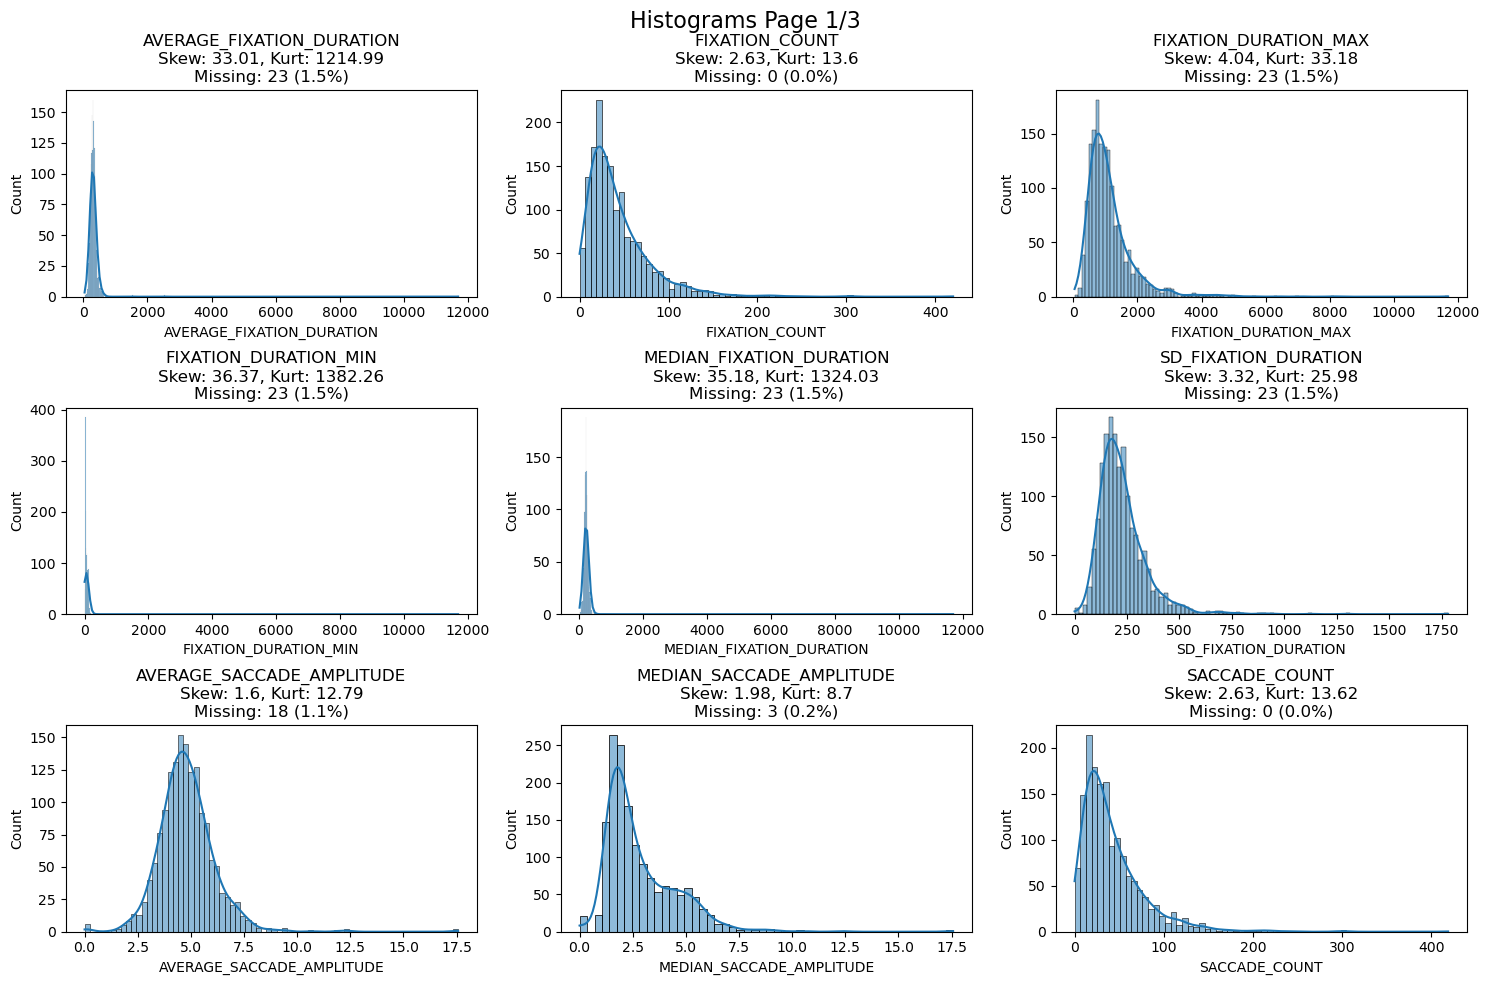

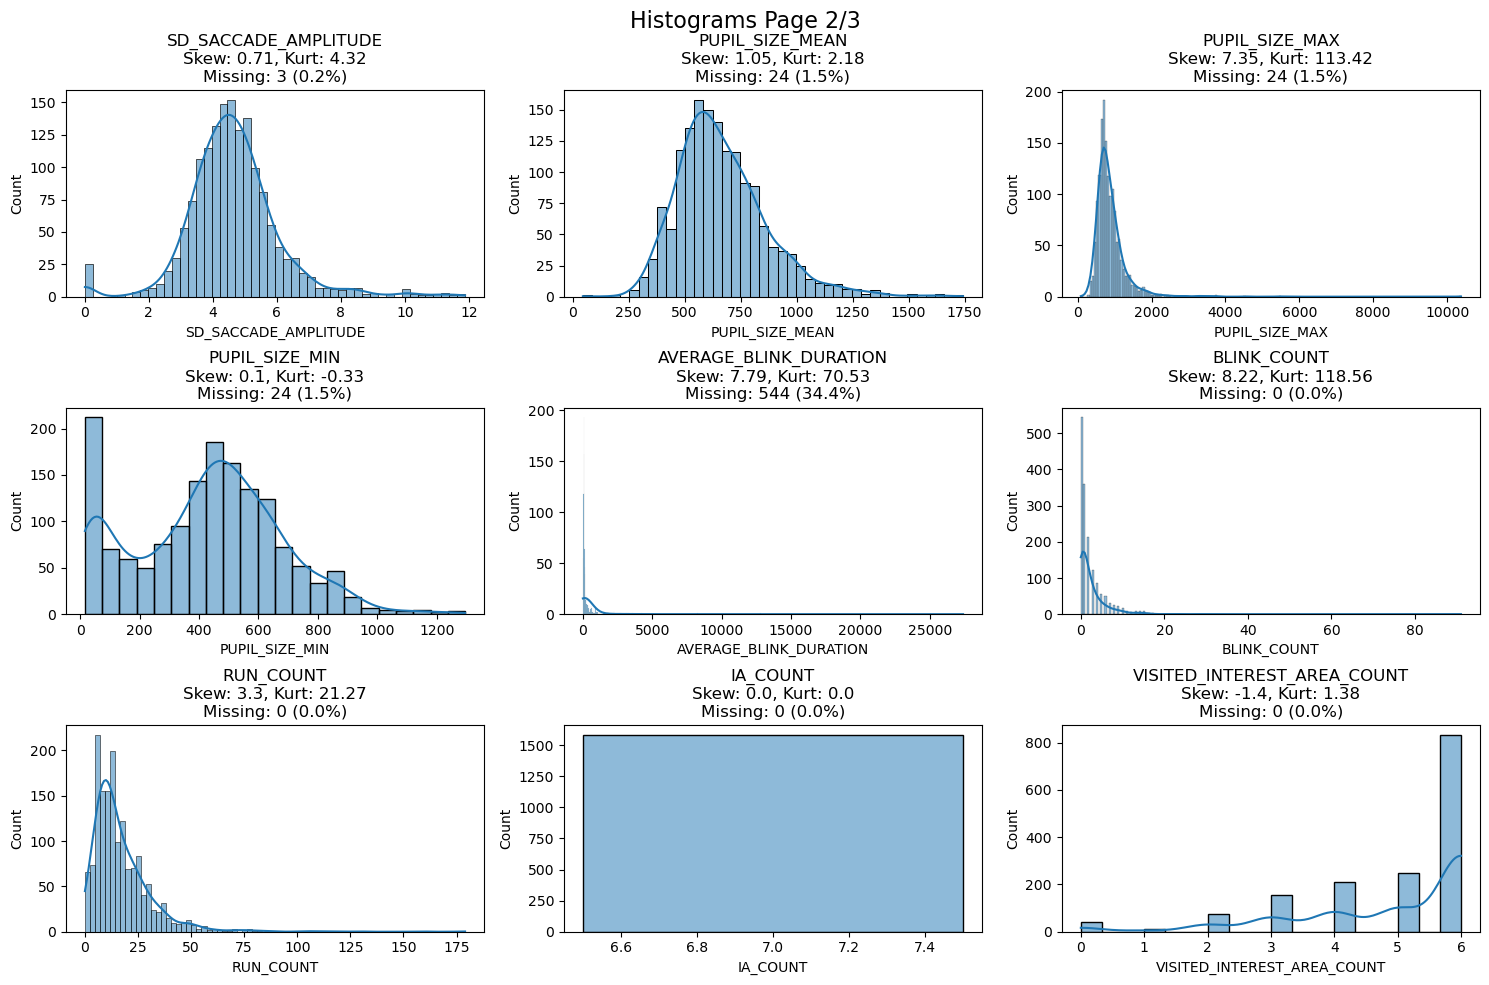

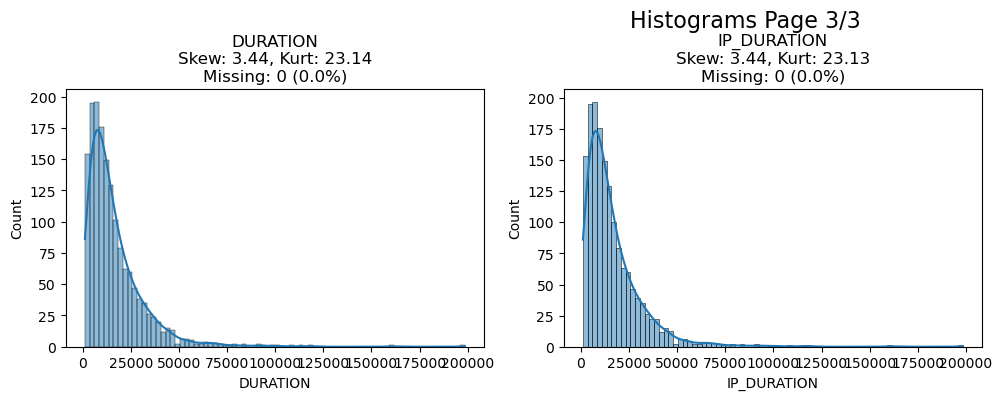

In [9]:
# Select all eye tracking metrics
metrics = [
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]


# Create a comprehensive descriptive statistics table
def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df[metrics].select_dtypes(include=['float64', 'int64'])

    # Basic statistics
    desc = numeric_df.describe().T
    
    # Add additional statistics
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    desc['median'] = numeric_df.median()
    desc['variance'] = numeric_df.var()
    desc['range'] = numeric_df.max() - numeric_df.min()
    desc['IQR'] = numeric_df.quantile(0.75) - numeric_df.quantile(0.25)
    desc['missing'] = numeric_df.isna().sum()
    desc['missing_pct'] = (numeric_df.isna().sum() / len(numeric_df)) * 100
    
    # Round all values to 2 decimal places for better readability
    desc = desc.round(2)
    
    return desc

# Apply the function to your dataframe
descriptive_table = descriptive_stats(df_selected_numeric)

# Display the table
print(descriptive_table)

# Output descriptive table of metrics
descriptive_table.to_csv("../data/eye_tracking_metrics_descriptive.csv", index=True)


# For a more visual representation, you can also create histograms with density plots to visualize skewness
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))


# Get only numeric columns
numeric_columns = df_selected_numeric.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_selected_numeric[numeric_columns].skew()

# Option 1: Show all metrics with multiple pages of plots
def plot_all_histograms(df, columns, plots_per_page=9):
    num_pages = math.ceil(len(columns) / plots_per_page)
    
    for page in range(num_pages):
        plt.figure(figsize=(15, 10))
        start_idx = page * plots_per_page
        end_idx = min((page + 1) * plots_per_page, len(columns))
        
        for i, column in enumerate(columns[start_idx:end_idx]):
            plt.subplot(3, 3, i + 1)
            sns.histplot(df[column].dropna(), kde=True)
            
            # Add multiple statistics to the title
            skew = df[column].skew().round(2)
            kurt = df[column].kurtosis().round(2)
            missing = df[column].isna().sum()
            missing_pct = (missing / len(df) * 100).round(1)
            
            plt.title(f'{column}\nSkew: {skew}, Kurt: {kurt}\nMissing: {missing} ({missing_pct}%)')
            plt.tight_layout()
        
        plt.suptitle(f'Histograms Page {page+1}/{num_pages}', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_selected_numeric, metrics)


### Summary of Metric Issues
Several of the selected eye-tracking and behavioral metrics exhibit significant distributional challenges, including high skewness, elevated kurtosis, negative skewness, and evidence of multimodal distributions. These non-normal characteristics can adversely impact machine learning model performance and may lead to unreliable or biased results if not properly addressed.

| Metric                      | Skew | Kurt | Issue         | Solution        |
|-----------------------------|------|------|---------------|-----------------|
| AVG_FIX_DUR                 | 33.0 |1215  | Extreme skew  | Log             |
| FIX_COUNT                   | 2.6  | 14   | Skew/kurt     | Log             |
| FIX_DUR_MAX                 | 4.0  | 33   | Skew/kurt     | Log             |
| FIX_DUR_MIN                 |36.4  |1382  | Extreme skew  | Log             |
| MED_FIX_DUR                 |35.2  |1324  | Extreme skew  | Log             |
| SD_FIX_DUR                  | 3.3  | 26   | Skew/kurt     | Log             |
| AVG_SACC_AMP                | 1.6  | 13   | Mild skew     | Sqrt            |
| MED_SACC_AMP                | 2.0  | 9    | Mild skew     | Sqrt            |
| SACC_COUNT                  | 2.6  | 14   | Skew/kurt     | Log             |
| SD_SACC_AMP                 | 0.7  | 4    | Mild kurt     | OK              |
| PUPIL_MEAN                  | 1.1  | 2    | Slight skew   | OK              |
| PUPIL_MAX                   | 7.4  |113   | Skew/kurt     | Log             |
| PUPIL_MIN                   | 0.1  |-0.3  | None          | OK              |
| AVG_BLINK_DUR               | 7.8  | 71   | Skew/kurt     | Log             |
| BLINK_COUNT                 | 8.2  |119   | Skew/kurt     | Log             |
| RUN_COUNT                   | 3.3  | 21   | Skew/kurt     | Log             |
| IA_COUNT                    | 0.0  | 0    | Constant      | Remove          |
| VISITED_IA_COUNT            |-1.4  | 1.4  | Neg. skew     | Reflect         |
| DURATION                    | 3.4  | 23   | Skew/kurt     | Log             |
| IP_DURATION                 | 3.4  | 23   | Skew/kurt     | Log             |

### Data is df_selected_numeric


In [12]:
# Map for transformations and suffixes
transforms = {
    "AVERAGE_FIXATION_DURATION":     ("log",       lambda x: np.log1p(x)),
    "FIXATION_COUNT":                ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MAX":         ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MIN":         ("log",       lambda x: np.log1p(x)),
    "MEDIAN_FIXATION_DURATION":      ("log",       lambda x: np.log1p(x)),
    "SD_FIXATION_DURATION":          ("log",       lambda x: np.log1p(x)),
    "AVERAGE_SACCADE_AMPLITUDE":     ("sqrt",      lambda x: np.sqrt(x)),
    "MEDIAN_SACCADE_AMPLITUDE":      ("sqrt",      lambda x: np.sqrt(x)),
    "SACCADE_COUNT":                 ("log",       lambda x: np.log1p(x)),
    "SD_SACCADE_AMPLITUDE":          (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MEAN":               (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MAX":                ("log",       lambda x: np.log1p(x)),
    "PUPIL_SIZE_MIN":                (None,        None),        # OK, no action needed
    "AVERAGE_BLINK_DURATION":        ("log",       lambda x: np.log1p(x)),
    "BLINK_COUNT":                   ("log",       lambda x: np.log1p(x)),
    "RUN_COUNT":                     ("log",       lambda x: np.log1p(x)),
    "IA_COUNT":                      ("remove",    None),        # Remove
    "VISITED_INTEREST_AREA_COUNT":   ("reflectlog",lambda x: np.log1p(reflect(x))),  # Reflect then log
    "DURATION":                      ("log",       lambda x: np.log1p(x)),
    "IP_DURATION":                   ("log",       lambda x: np.log1p(x)),
}

df_transformed = df_selected_numeric.copy()



def reflect(x):
    return x.max() + 1 - x

for col, (suffix, transform) in transforms.items():
    if col not in df_transformed.columns:
        continue

    if suffix is None:
        continue  # No transformation, keep original
    elif suffix == "remove":
        df_transformed.drop(columns=[col], inplace=True)
    else:
        new_col_name = f"{col}_{suffix}"
        df_transformed[new_col_name] = transform(df_transformed[col])

# keep only transformed columns:
#keep_cols = [f"{col}_{suffix}" for col, (suffix, _) in transforms.items() if suffix not in (None, "remove")]
#df_final = df_transformed[keep_cols]

# View transformed DataFrame
df_transformed.head()


,RECORDING_SESSION_LABEL,trialid,response,AVERAGE_FIXATION_DURATION,FIXATION_COUNT,FIXATION_DURATION_MAX,FIXATION_DURATION_MIN,MEDIAN_FIXATION_DURATION,SD_FIXATION_DURATION,AVERAGE_SACCADE_AMPLITUDE,...,AVERAGE_SACCADE_AMPLITUDE_sqrt,MEDIAN_SACCADE_AMPLITUDE_sqrt,SACCADE_COUNT_log,PUPIL_SIZE_MAX_log,AVERAGE_BLINK_DURATION_log,BLINK_COUNT_log,RUN_COUNT_log,VISITED_INTEREST_AREA_COUNT_reflectlog,DURATION_log,IP_DURATION_log
0,ET24_066,4,1,366.88,57,1011.0,90.0,368.0,198.33,5.45,...,2.334524,2.044505,4.043051,6.539586,4.948760,1.386294,3.496508,0.693147,10.077441,10.073863
1,ET24_066,12,1,354.98,57,1134.0,36.0,308.0,206.06,5.54,...,2.353720,1.360147,4.060443,6.577861,5.187386,1.791759,3.295837,0.693147,10.073230,10.069849
2,ET24_066,1,1,NaN,0,NaN,NaN,NaN,NaN,12.28,...,3.504283,3.504283,0.693147,NaN,8.663715,0.693147,0.000000,2.079442,8.670086,8.654517
3,ET24_066,18,0,NaN,0,NaN,NaN,NaN,NaN,12.40,...,3.521363,3.521363,0.693147,NaN,9.514953,0.693147,0.000000,2.079442,9.517678,9.511851
4,ET24_066,6,1,206.57,7,416.0,8.0,234.0,142.05,8.63,...,2.937686,2.561250,2.079442,6.269096,8.957511,1.098612,1.791759,1.098612,9.761348,9.756784


## Descriptive summary after transformation

                                         count        mean         std  \
AVERAGE_FIXATION_DURATION_log           1559.0    5.684923    0.306911   
FIXATION_COUNT_log                      1582.0    3.474602    0.855799   
FIXATION_DURATION_MAX_log               1559.0    6.866475    0.548522   
FIXATION_DURATION_MIN_log               1559.0    3.867271    0.773623   
MEDIAN_FIXATION_DURATION_log            1559.0    5.443176    0.304428   
SD_FIXATION_DURATION_log                1559.0    5.311169    0.542014   
AVERAGE_SACCADE_AMPLITUDE_sqrt          1564.0    2.168823    0.308255   
MEDIAN_SACCADE_AMPLITUDE_sqrt           1579.0    1.617905    0.474758   
SACCADE_COUNT_log                       1582.0    3.454023    0.838961   
SD_SACCADE_AMPLITUDE                    1579.0    4.642888    1.446659   
PUPIL_SIZE_MEAN                         1558.0  666.448543  200.861462   
PUPIL_SIZE_MAX_log                      1558.0    6.710114    0.372079   
PUPIL_SIZE_MIN                        

<Figure size 1500x1000 with 0 Axes>

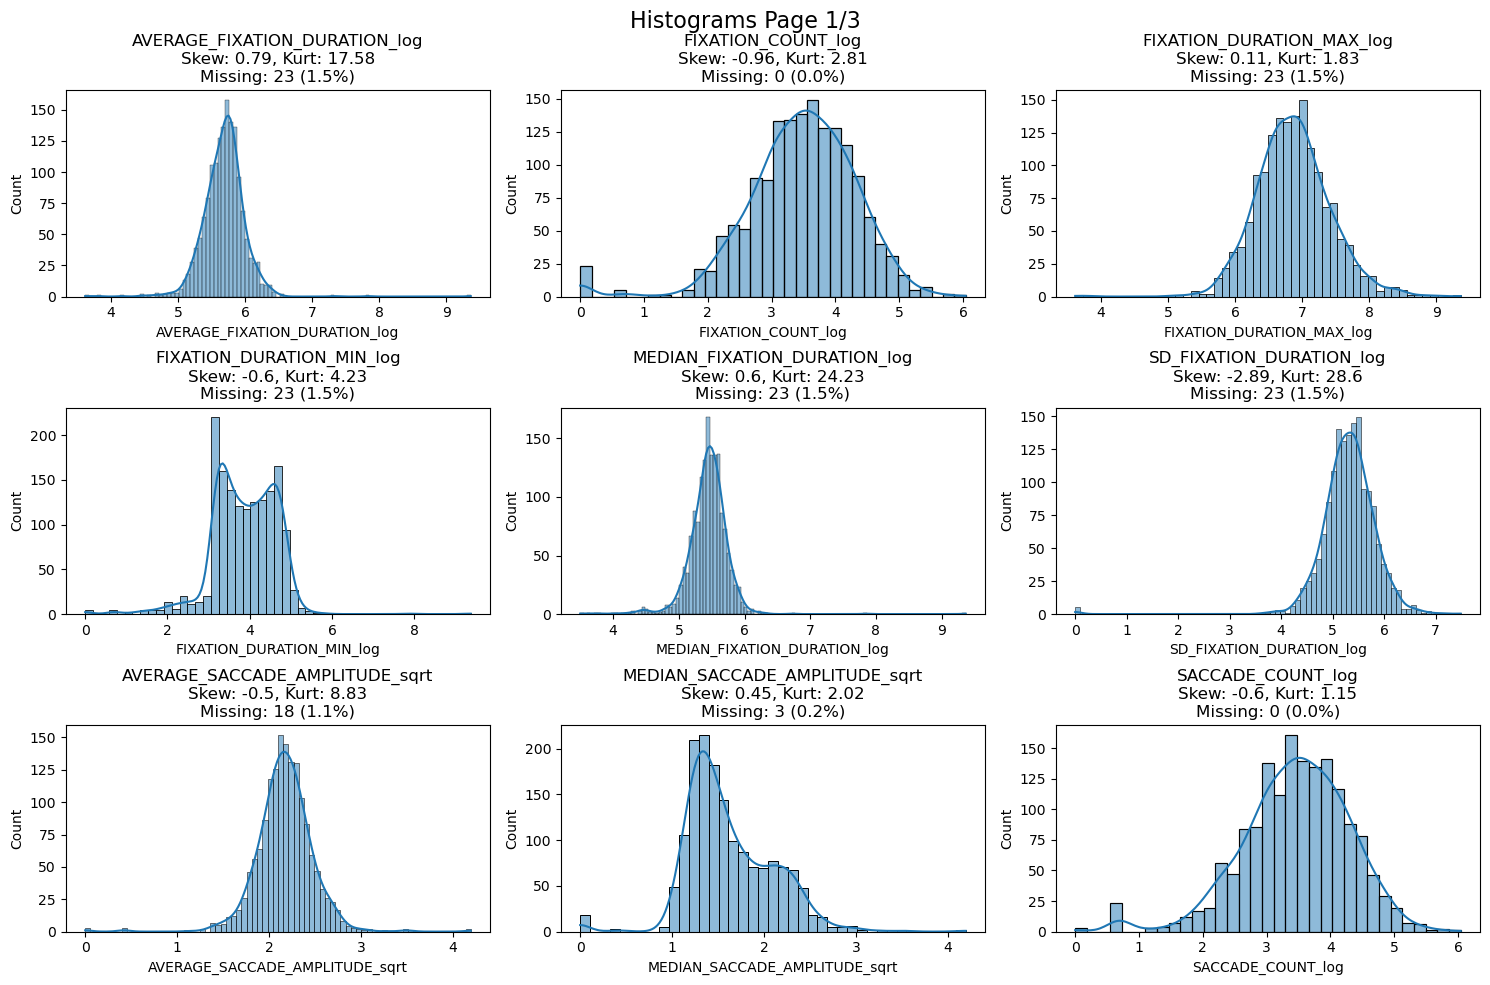

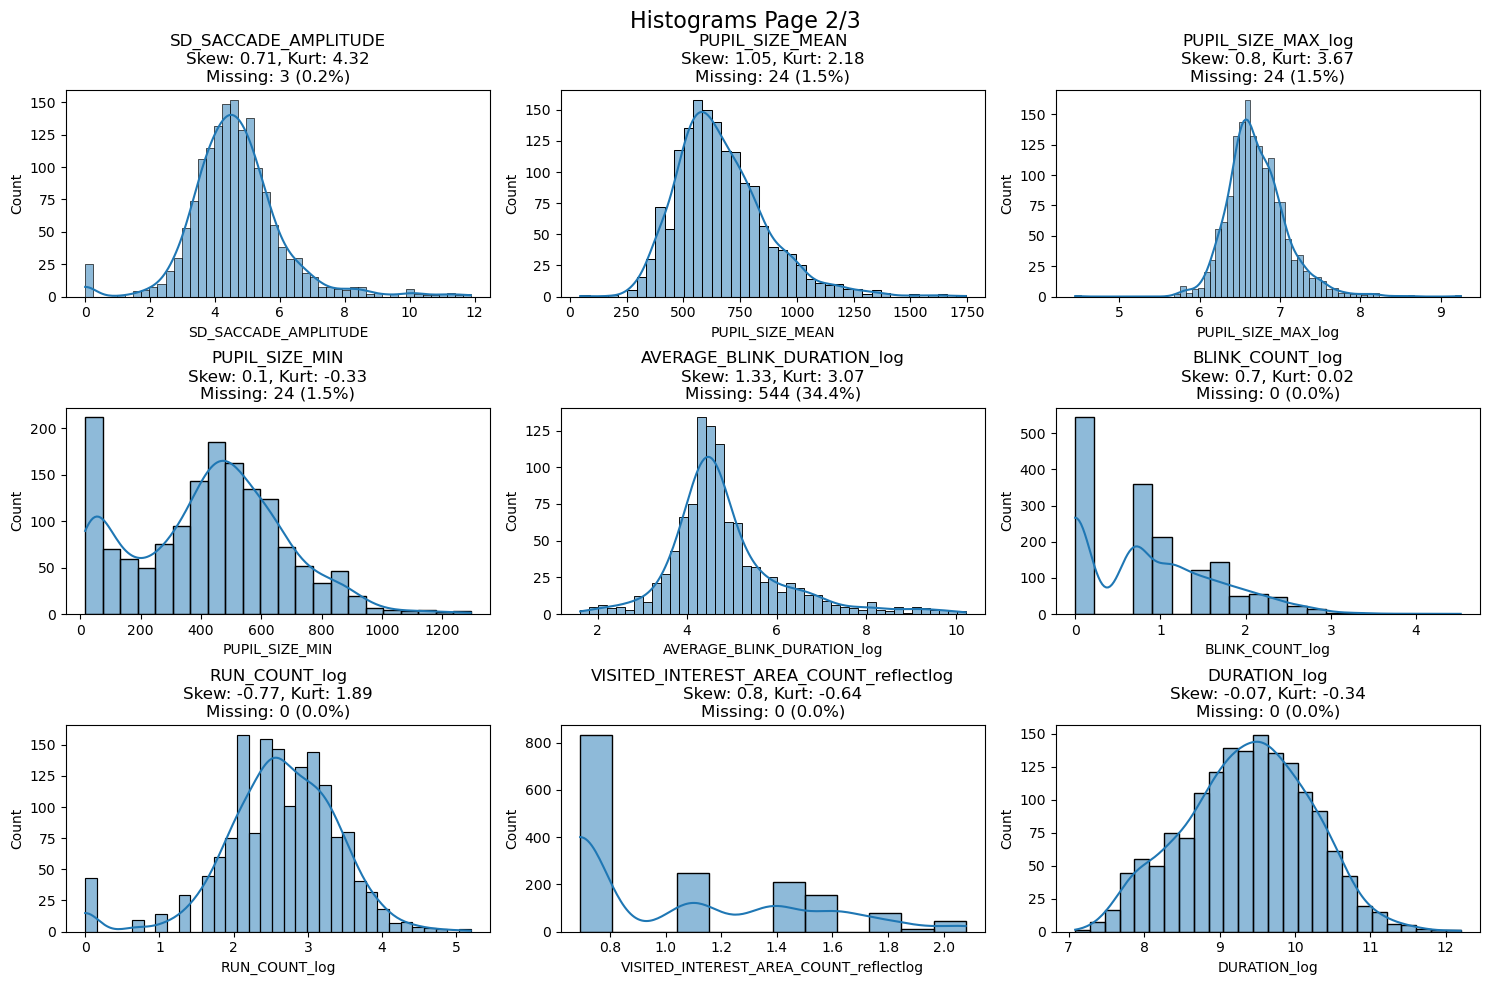

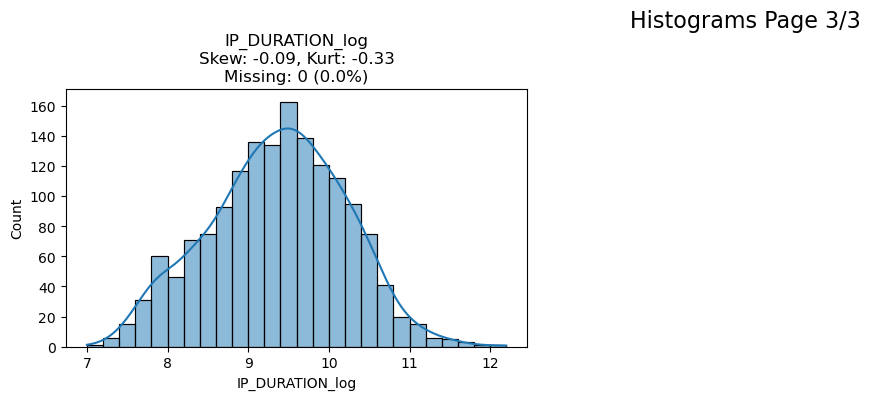

In [13]:
# List of new transformed variables
transformed_vars = [
    "AVERAGE_FIXATION_DURATION_log",
    "FIXATION_COUNT_log",
    "FIXATION_DURATION_MAX_log",
    "FIXATION_DURATION_MIN_log",
    "MEDIAN_FIXATION_DURATION_log",
    "SD_FIXATION_DURATION_log",
    "AVERAGE_SACCADE_AMPLITUDE_sqrt",
    "MEDIAN_SACCADE_AMPLITUDE_sqrt",
    "SACCADE_COUNT_log",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN", 
    "PUPIL_SIZE_MAX_log",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION_log",
    "BLINK_COUNT_log",
    "RUN_COUNT_log",
    "VISITED_INTEREST_AREA_COUNT_reflectlog",
    "DURATION_log",
    "IP_DURATION_log"
]

def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Basic statistics
    desc = numeric_df.describe().T
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    return desc

# Apply the function to your dataframe
descriptive_table_transformed = descriptive_stats(df_transformed[transformed_vars])

# Display the table
print(descriptive_table_transformed)

# Output descriptive table of metrics
descriptive_table_transformed.to_csv("../data/eye_tracking_metrics_descriptive_transformed.csv", index=True)



# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Get only numeric columns
numeric_columns = df_transformed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_transformed[transformed_vars].skew()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_transformed, transformed_vars)

## Standardization

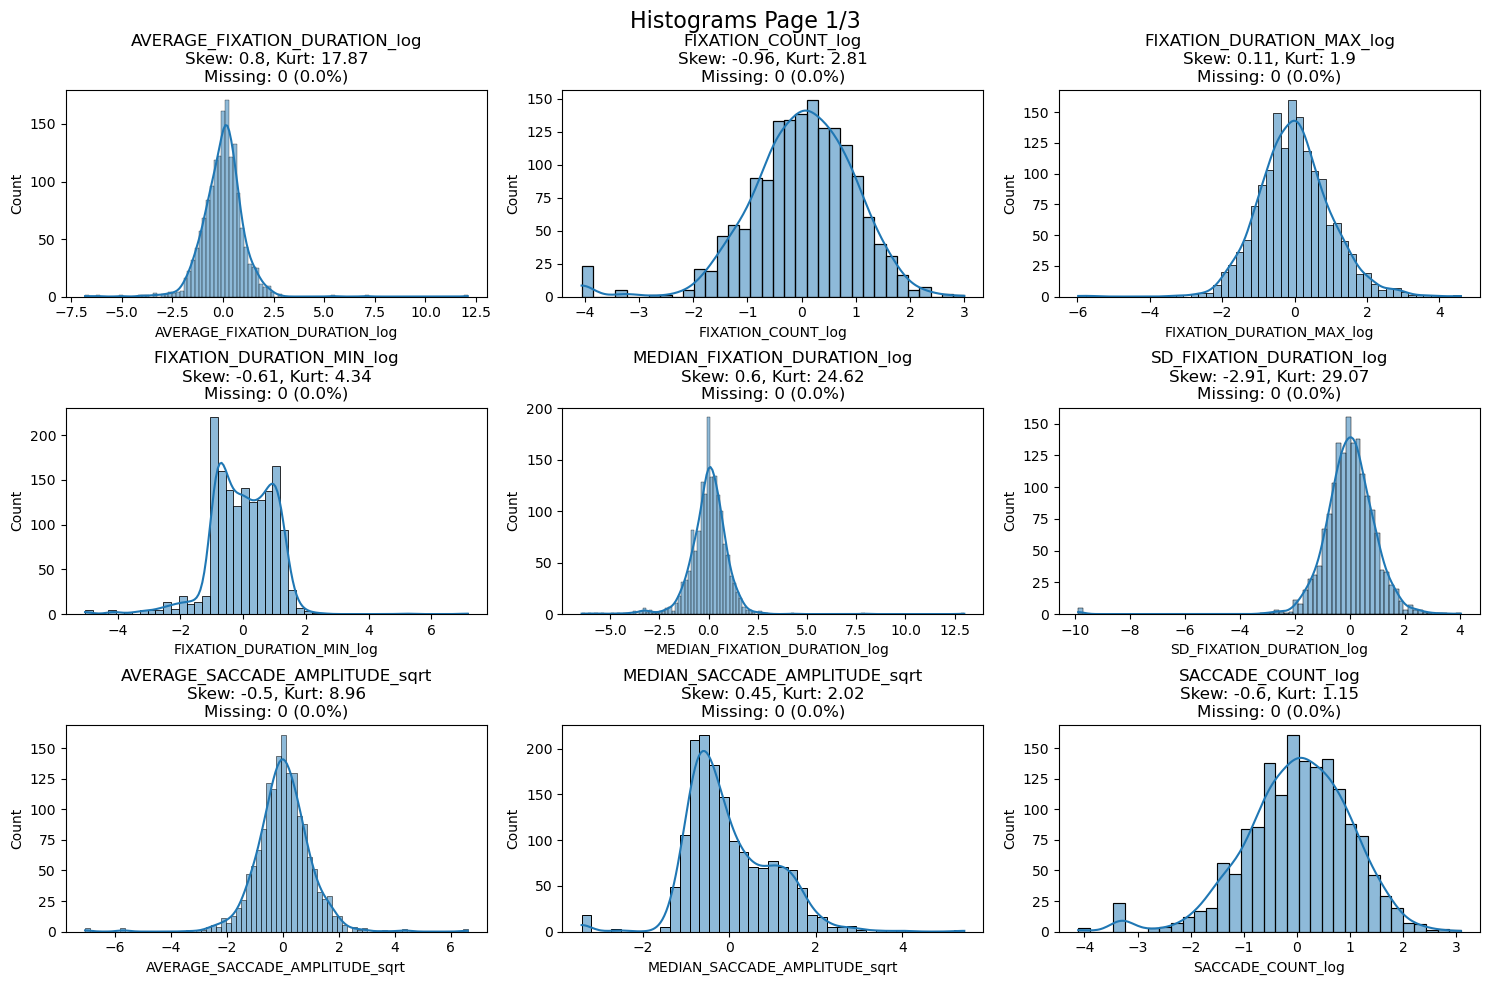

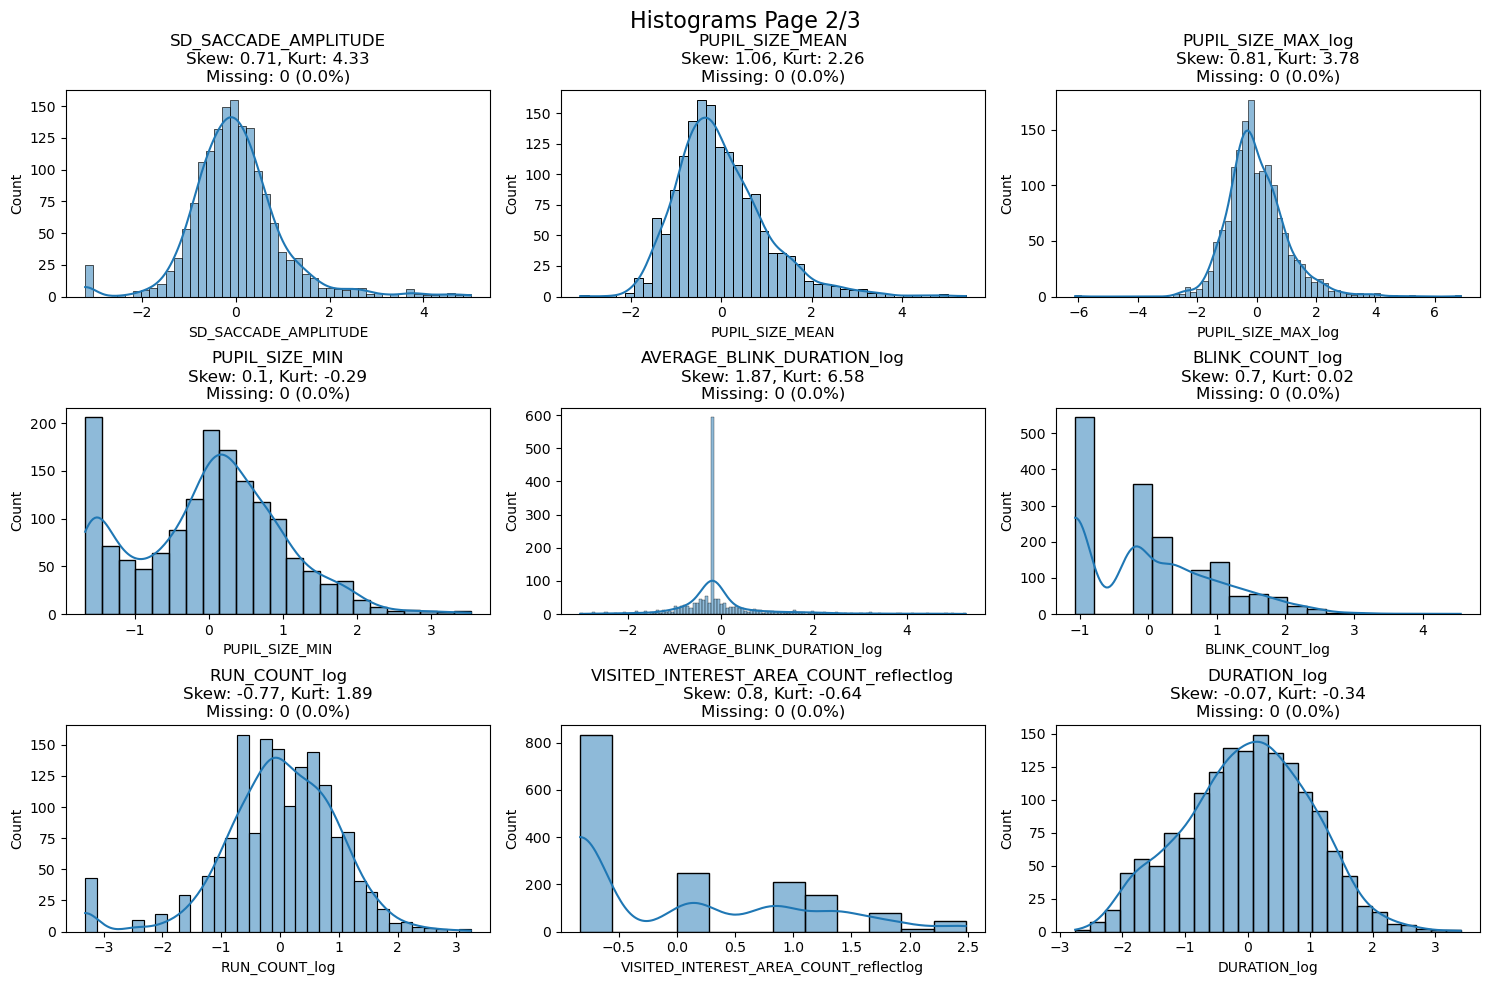

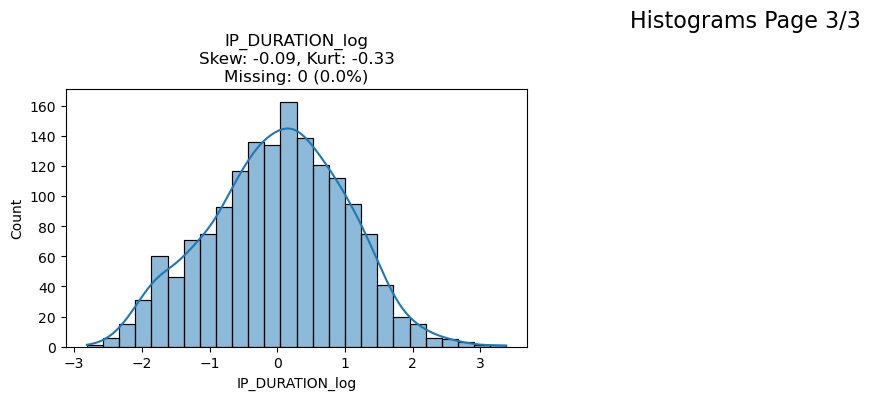

In [14]:
# Decide on imputation strategy (mean/median imputation, KNN, model-based)

# Create a copy for imputation
df_fill = df_transformed.copy()

# Impute missing values
df_fill[transformed_vars] = df_fill[transformed_vars].fillna(df_fill[transformed_vars].median())

# Create a new copy for standardization
df_standardized = df_fill.copy()

# Standardize the selected columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized[transformed_vars] = scaler.fit_transform(df_fill[transformed_vars])

# Plot histograms (fix variable name typo)
plot_all_histograms(df_standardized, transformed_vars)


### Feature Selection or Dimensionality Reduction

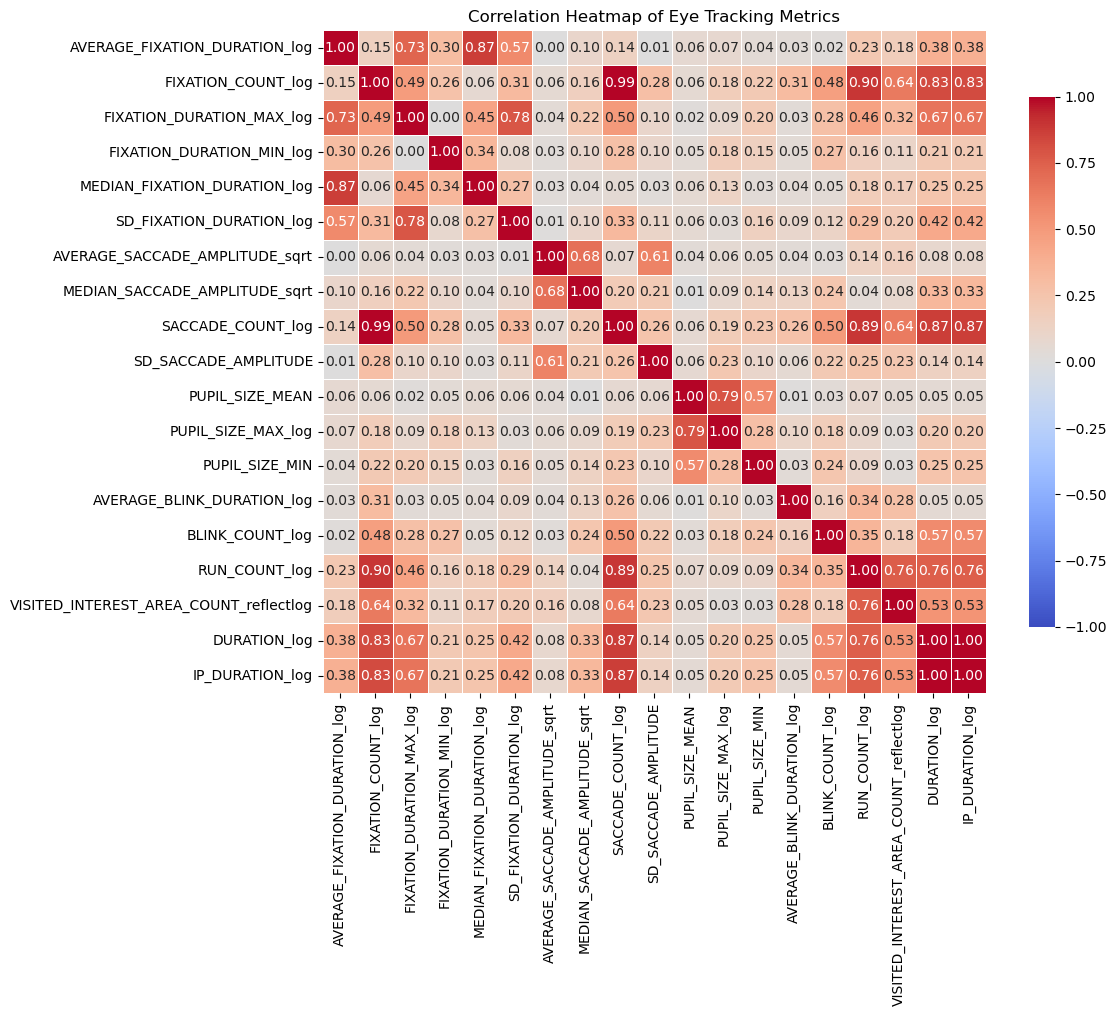

['FIXATION_DURATION_MAX_log', 'MEDIAN_FIXATION_DURATION_log', 'SD_FIXATION_DURATION_log', 'SACCADE_COUNT_log', 'PUPIL_SIZE_MAX_log', 'RUN_COUNT_log', 'VISITED_INTEREST_AREA_COUNT_reflectlog', 'DURATION_log', 'IP_DURATION_log']


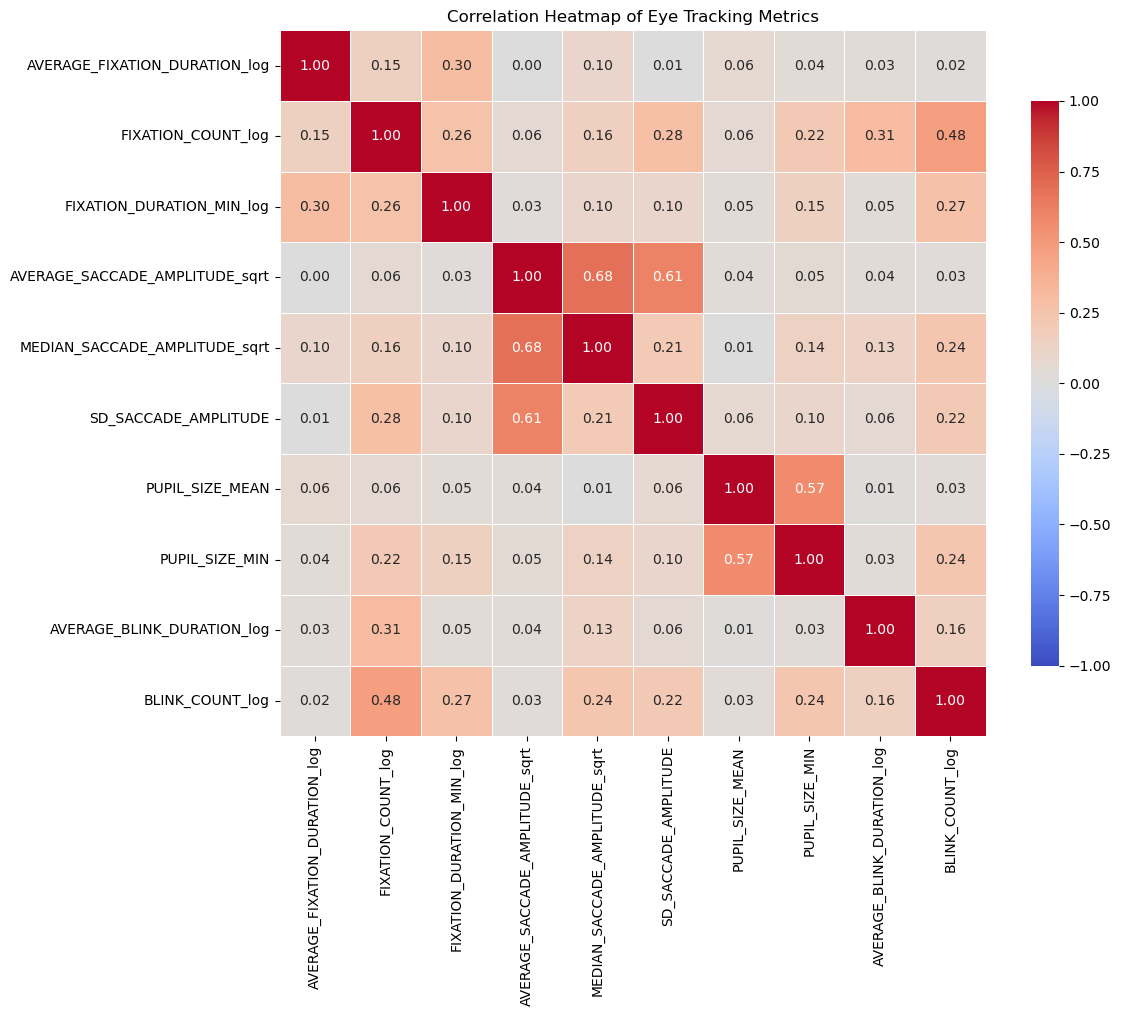

In [61]:
# Use only numeric columns for correlation calculation:
corr_matrix = df_standardized[transformed_vars].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]


# Drop from df_standardized (numeric part only)
df_final = df_standardized.drop(columns=to_drop)



plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


print(to_drop)
after_cor_checking_vars = [col for col in transformed_vars if col not in to_drop]


corr_matrix = df_standardized[after_cor_checking_vars].corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


### PCA (Principal Component Analysis)

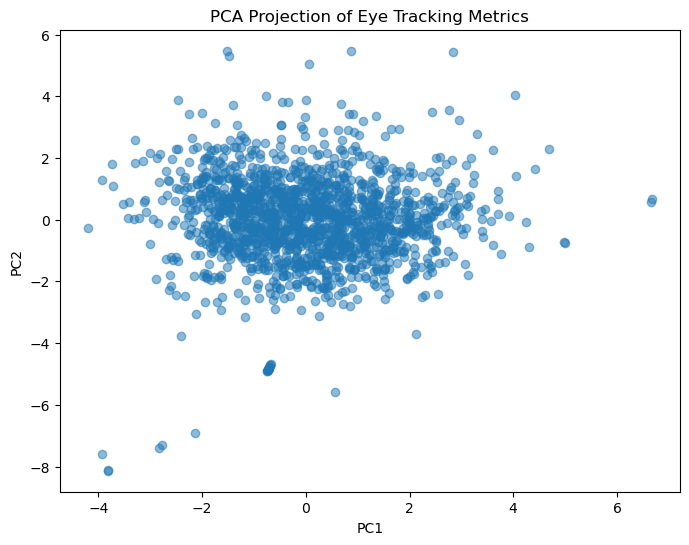

In [62]:
# Now run PCA using the available columns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_standardized[after_cor_checking_vars])

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Eye Tracking Metrics")
plt.show()


### Exploratory Data Analysis (EDA)

### Unsupervised: Cluster analysis (K-means, hierarchical, DBSCAN), PCA, t-SNE, UMAP.

### Clustering (K-means)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


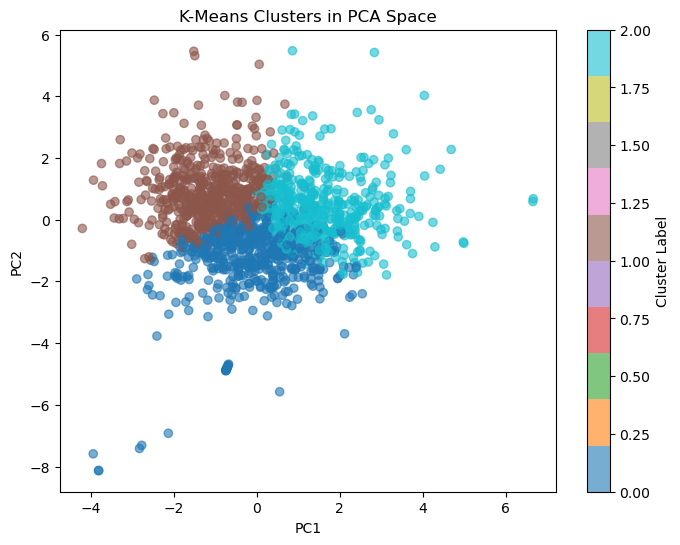

In [63]:
from sklearn.cluster import KMeans

# Try 2-5 clusters and plot (choose best by silhouette score or elbow method)
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(df_standardized[after_cor_checking_vars])

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters in PCA Space")
plt.colorbar(label='Cluster Label')
plt.show()


### t-SNE Visualization

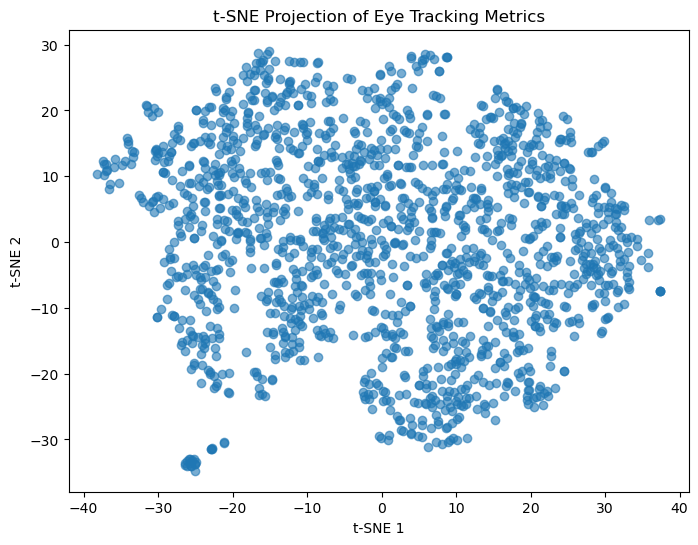

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE (may take 1-2 minutes for large datasets)
tsne = TSNE(n_components=2, perplexity=45, random_state=0)
X_tsne = tsne.fit_transform(df_standardized[after_cor_checking_vars])

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection of Eye Tracking Metrics")
plt.show()



###  UMAP Visualization

### DBSCAN

Silhouette Score (DBSCAN): 0.2


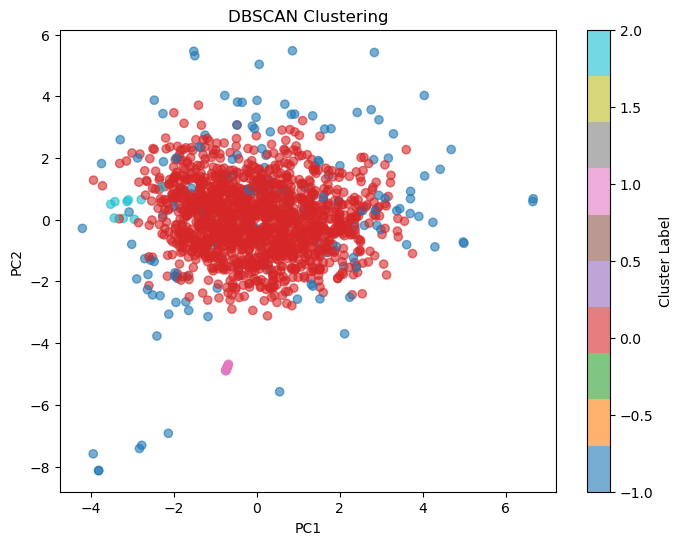

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

db = DBSCAN(eps=1.0, min_samples=5).fit(X_pca)  # or X_umap for better results
labels_dbscan = db.labels_

# Silhouette score (ignoring noise points labeled -1)
if len(set(labels_dbscan)) > 1:
    score = silhouette_score(X_pca, labels_dbscan)
    print("Silhouette Score (DBSCAN):", round(score, 2))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.6)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.show()


In [ ]:
### Agglomerative Clustering (Hierarchical)

### Gaussian Mixture Models (GMM)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


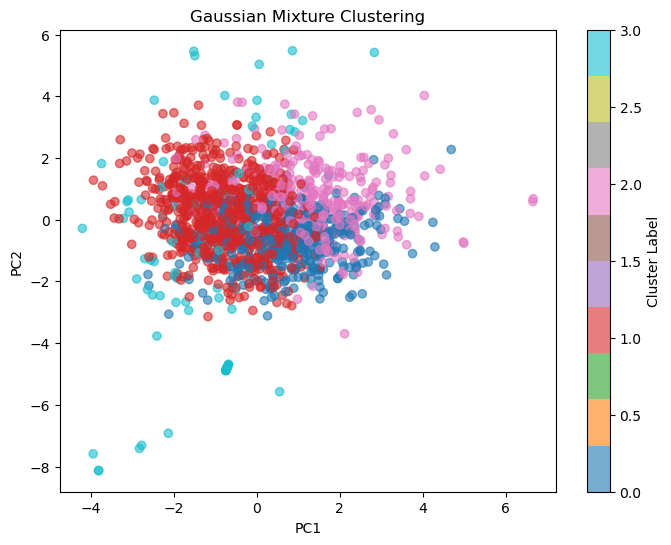

In [67]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=0)
labels_gmm = gmm.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap='tab10', alpha=0.6)
plt.title("Gaussian Mixture Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.show()


### Isolation Forest for Exploratory Anomaly Detection

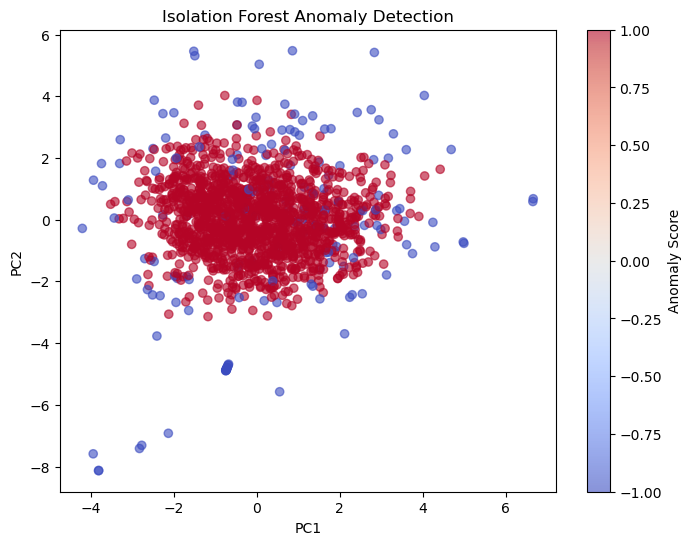

In [68]:
from sklearn.ensemble import IsolationForest

# Fit model
iso = IsolationForest(contamination=0.1, random_state=0)
df_standardized["anomaly_score"] = iso.fit_predict(df_standardized[after_cor_checking_vars])

# Visualize with PCA or UMAP
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_standardized["anomaly_score"], cmap='coolwarm', alpha=0.6)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="Anomaly Score")
plt.show()


In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized[after_cor_checking_vars])
df_standardized['cluster'] = cluster_labels


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [70]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(df_standardized[after_cor_checking_vars], df_standardized['cluster'])
feature_importances = rf.feature_importances_
feature_importances


array([0.03598865, 0.10462481, 0.06390375, 0.16326632, 0.15106535,
       0.09589369, 0.05615197, 0.12113321, 0.02651267, 0.18145957])

In [71]:
# Create a DataFrame to show importance
importance_df = pd.DataFrame({
    'Feature': after_cor_checking_vars,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                          Feature  Importance
9                 BLINK_COUNT_log    0.181460
3  AVERAGE_SACCADE_AMPLITUDE_sqrt    0.163266
4   MEDIAN_SACCADE_AMPLITUDE_sqrt    0.151065
7                  PUPIL_SIZE_MIN    0.121133
1              FIXATION_COUNT_log    0.104625
5            SD_SACCADE_AMPLITUDE    0.095894
2       FIXATION_DURATION_MIN_log    0.063904
6                 PUPIL_SIZE_MEAN    0.056152
0   AVERAGE_FIXATION_DURATION_log    0.035989
8      AVERAGE_BLINK_DURATION_log    0.026513


### Use accuracy as supervised label

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


numeric_cols = after_cor_checking_vars.copy()
df_final = df_standardized.copy()

# 1. Define X and y
X = df_final[numeric_cols]
y = df_final['response']  # or 'accuracy', assuming 0/1 values

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Fit a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 4. Evaluate performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62       252
           1       0.55      0.45      0.50       223

    accuracy                           0.57       475
   macro avg       0.56      0.56      0.56       475
weighted avg       0.56      0.57      0.56       475

[[168  84]
 [122 101]]


In [73]:
importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))


                          Feature  Importance
0   AVERAGE_FIXATION_DURATION_log    0.125806
1              FIXATION_COUNT_log    0.125578
3  AVERAGE_SACCADE_AMPLITUDE_sqrt    0.114668
4   MEDIAN_SACCADE_AMPLITUDE_sqrt    0.107846
6                 PUPIL_SIZE_MEAN    0.105414
7                  PUPIL_SIZE_MIN    0.098516
5            SD_SACCADE_AMPLITUDE    0.095461
2       FIXATION_DURATION_MIN_log    0.093469
8      AVERAGE_BLINK_DURATION_log    0.089984
9                 BLINK_COUNT_log    0.043258


In [74]:
# Aggregate features per participant or per task
agg_df = df_final.groupby('RECORDING_SESSION_LABEL').agg({
    'FIXATION_COUNT_log': ['mean', 'std'],
    'PUPIL_SIZE_MEAN': ['mean', 'std'],
    ...
    'response': 'mean'  # This becomes your aggregated score
})
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]


SyntaxError: ':' expected after dictionary key (3988988381.py, line 5)